## Import important dependencies and paths

In [1]:
import os 
import numpy as np
import pandas as pd
from clustering import *
from data_preparation import *
from docking import *
from rdkit.ML.Cluster import Butina
from rdkit import Chem, DataStructs
from rdkit.Chem import PandasTools, SDMolSupplier, AllChem, rdFingerprintGenerator
from scipy.stats import spearmanr
from matplotlib import pyplot as plt
from utility import rank_correlation, prcoess_ranking_data, consensus_ranking_generator

#To disaply warning messages
RDLogger.DisableLog('rdApp.*')  

#### If there is more than one snapshot of a trajectory.
    - make a directory for all snapshots inside **data** directory
    - For now , we work with snapshot A

In [2]:
snapshot_ID = 'A'
protein_file = f"data/{snapshot_ID}/protein_protoss_noligand.pdb"
ref_file = f"data/{snapshot_ID}/ref_ligand.pdb"

### Load IC50 data

In [3]:
df_IC50 = create_IC50_sample()
df_IC50.head()

IC50 Molecules already exist.


,Activity,smiles,ID,Molecule
0,3.1,O=C(O)c1cc(OCc2cccc(-c3cccc(Oc4ccc(C(F)(F)F)cc...,HIPS6989,<rdkit.Chem.rdchem.Mol object at 0x7f1f1f548f90>
1,3.2,O=C(O)c1cc(OCc2cccc(-c3cccc(OCc4ccc(OC(F)(F)F)...,HIPS7002,<rdkit.Chem.rdchem.Mol object at 0x7f1f1f548eb0>
2,3.5,O=C(O)c1cc(OCc2cccc(-c3cccc(OCc4ccc(C(F)(F)F)c...,HIPS7000,<rdkit.Chem.rdchem.Mol object at 0x7f1f1f5780b0>
3,4.7,Cc1ccc(Oc2cccc(-c3cccc(COc4ccc(O)c(C(=O)O)c4)c...,HIPS6994,<rdkit.Chem.rdchem.Mol object at 0x7f1f1f578190>
4,5.0,O=C(O)c1cc(OCc2cccc(-c3cccc(Oc4ccc(Cl)cc4)c3)c...,HIPS6991,<rdkit.Chem.rdchem.Mol object at 0x7f1f1f578270>


### Prepare larger dataset with negative samples with already calculated score.

In [4]:
data_name = 'ecft_scores'
data_size, df_scores = add_negative_data(data_name)
print(f"Now we have loaded {data_size} molecules save in data/ligands/{data_name}.sdf, which contains negative samples.")

,HIPS code,Lab code,MW,logS,logS @ pH7.4,logD,logP,HBD,HBA,TPSA,Flexibility,Rotatable Bonds,ID,ROMol,score
311,HIPS314,MZ045,245.2,3.451,3.494,2.218,2.018,1,5,74.17,0.1667,3,StarDrop ID 312,<rdkit.Chem.rdchem.Mol object at 0x7f1f1f461c10>,0.493686
337,HIPS341,JHS014,449.4,-0.8367,2.185,2.827,5.787,2,5,69.64,0.2581,8,StarDrop ID 338,<rdkit.Chem.rdchem.Mol object at 0x7f1f1f46f7b0>,-0.265965
338,HIPS342,JHS015,415.3,-0.3106,2.281,2.323,5.668,3,5,78.43,0.3704,10,StarDrop ID 339,<rdkit.Chem.rdchem.Mol object at 0x7f1f1f46f820>,-0.371074
339,HIPS343,JHS017,421.3,-0.3253,2.435,2.421,5.322,3,5,78.43,0.2414,7,StarDrop ID 340,<rdkit.Chem.rdchem.Mol object at 0x7f1f1f46f890>,-0.357913
341,HIPS345,JHS021,435.3,-0.5078,2.529,2.489,5.526,2,5,69.64,0.2333,7,StarDrop ID 342,<rdkit.Chem.rdchem.Mol object at 0x7f1f1f46f970>,-0.550434


Now we have loaded 212 molecules save in data/ligands/ecft_scores.sdf, which contains negative samples.


#### Map correlation between IC50 data and score data

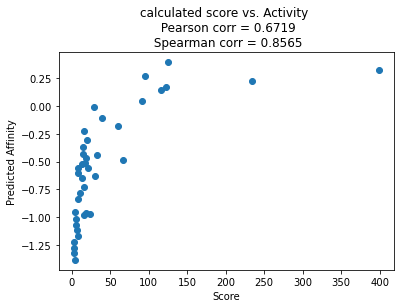

In [5]:
df_IC50.rename(columns = {'ID':'HIPS code'}, inplace = True)
merged_df_data = pd.merge(df_IC50, df_scores, on="HIPS code", how="left")
merged_df_data[['score', 'Activity']] = merged_df_data[['score', 'Activity']].apply(pd.to_numeric)

pearson_corr = merged_df_data['Activity'].corr(merged_df_data['score'])
spearman_corr = merged_df_data[['Activity', 'score']].corr(method='spearman').iloc[0,1]

plt.scatter(merged_df_data['Activity'], merged_df_data['score'])
plt.xlabel('Score')
plt.ylabel('Predicted Affinity')
plt.title(f'calculated score vs. Activity \n Pearson corr = {pearson_corr:.4f}\n Spearman corr = {spearman_corr:.4f}')
plt.show()

### Extract common IDs from score data and IC50 data

In [6]:
common_ID = df_scores[df_scores['HIPS code'].isin(df_IC50['HIPS code'])]['HIPS code']

print(f"There are {len(common_ID)} structures that found to be common in both data sets.")

There are 39 structures that found to be common in both data sets.



### Data preparation
####  1. Protein is prepared with protoss on ProteinPlus server (Done).
####  2. Ligand will be prepared using Gypsum-DL.

In [7]:
# Determine path of data set and run Gypsum-dl
prepared_molecules_path = run_gypsumdl(f"data/ligands/{data_name}.sdf", f"gypsum_dl_success_cleaned_{data_size}.sdf")

Molecules are already prepared


## Docking

## 1. DiffDOCK
### Prepare ligand protein csv file for DiffDock

### Run DiffDock (Left to run on cluster)

In [8]:
#run_diffdock(snapshot_ID, data_size)
len(df_scores.loc[df_scores['HIPS code'].isin(common_ID), 'score'].sort_values())

39

## 2. GNINA 1.0 docking 
### with -cnn crossdock_default2018

#### Run GNINA docking

In [9]:
sdf_name = f'docked_gnina_poses_{snapshot_ID}_{data_size}.sdf'

In [10]:
gnina_docking(snapshot_ID, sdf_name, prepared_molecules_path, ref_file)

Snapshot A is already docked with GNINA v 1.0


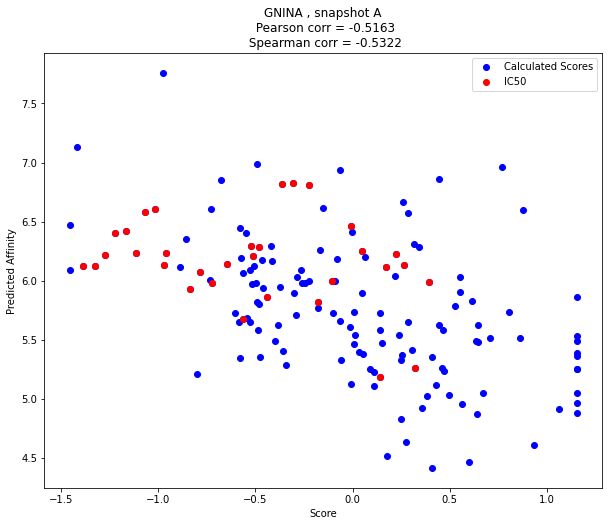

In [11]:
gnina_results_path = f'data/{snapshot_ID}/{sdf_name}'
rank_correlation(gnina_results_path, common_ID)

### SMINA docking

#### Run SMINA docking --cnn_scoring=none

In [12]:
sdf_name = f'docked_smina_poses_{snapshot_ID}_{data_size}.sdf'

In [13]:
smina_docking(snapshot_ID, sdf_name, prepared_molecules_path, ref_file)

Snapshot A is already docked with SMINA


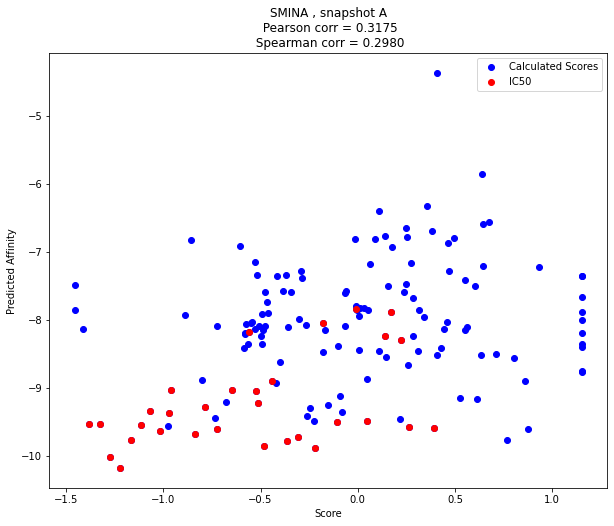

In [14]:
smina_results_path = f'data/{snapshot_ID}/{sdf_name}'
rank_correlation(smina_results_path, common_ID)

### Try rescoring function with every

rescoring directory is already created.
SMINA is now rescored ... 



RF-SCORE-VS Running ... 





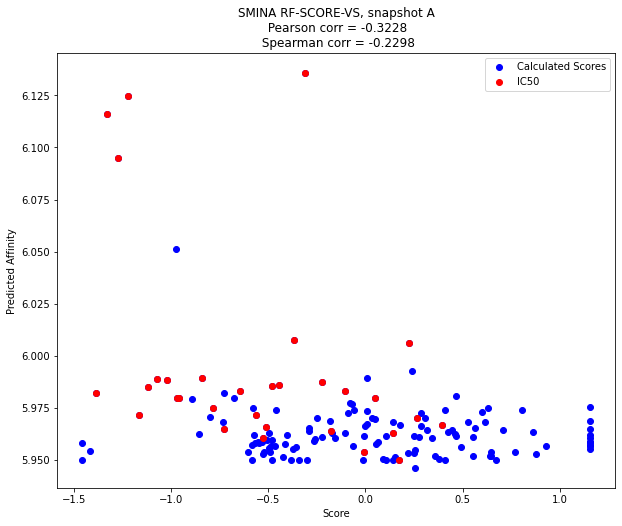

VINARDO Running ... 





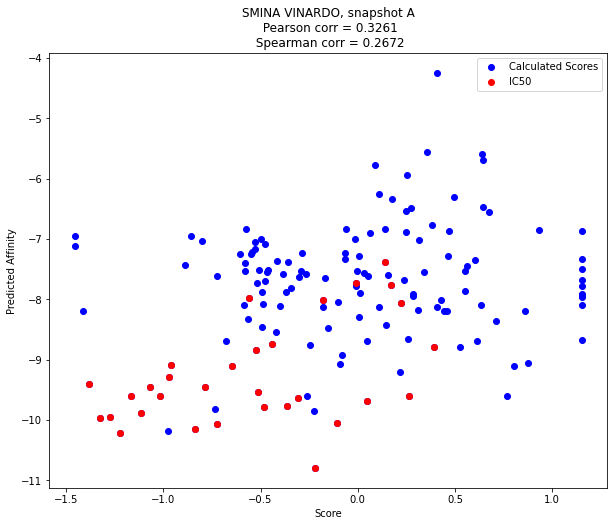

AD4 Running ... 





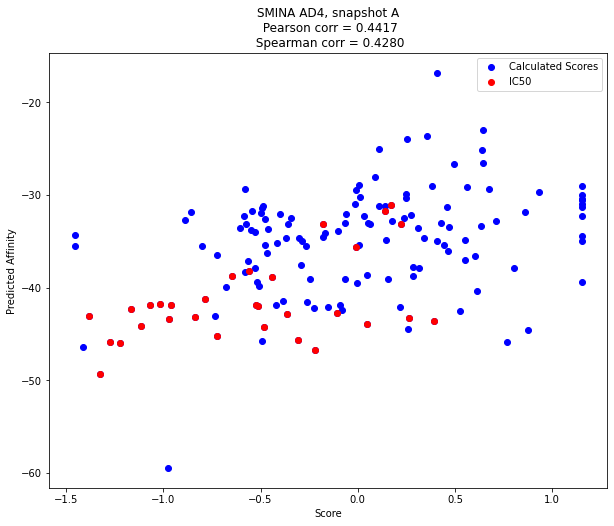

GNINA is now rescored ... 



RF-SCORE-VS Running ... 





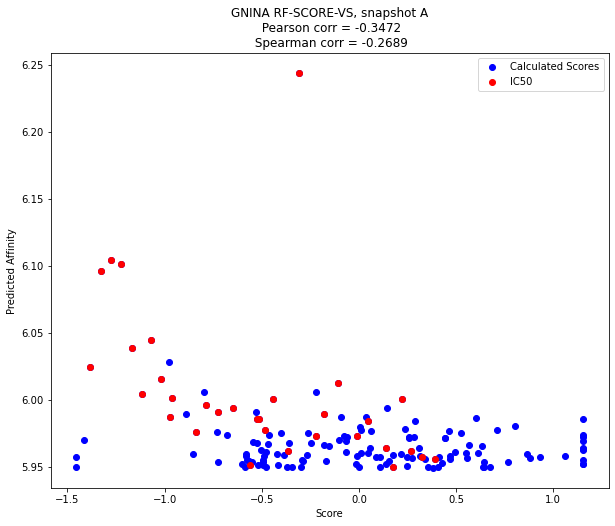

VINARDO Running ... 





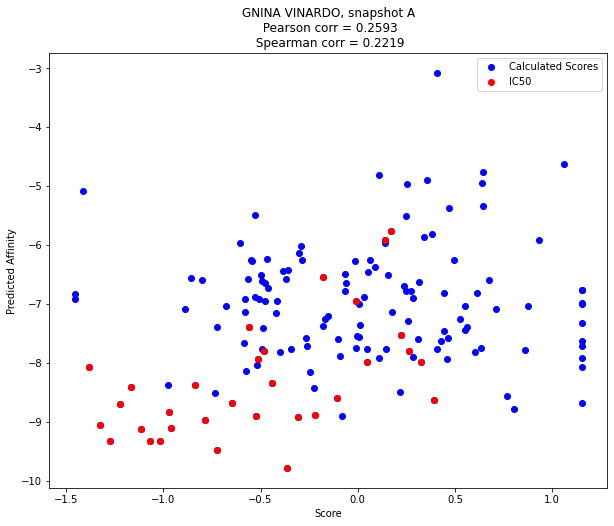

AD4 Running ... 





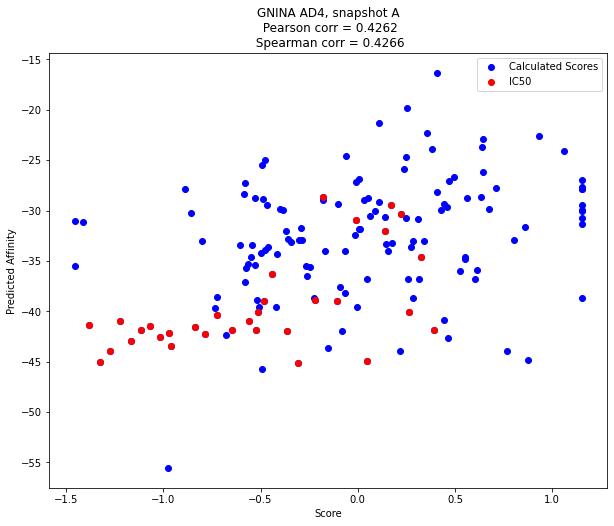

In [15]:
from rescoring import rescoring_functions
rescoring_functions(['smina', 'gnina'], ['rf-score-vs', 'vinardo', 'ad4'], snapshot_ID, data_size, common_ID)

### FP generating and clustering based on Tanimoto similarity metric for larger data

In [16]:
# Add column with Morgan fingerprint
docked_df = PandasTools.LoadSDF(gnina_results_path, idName='ID', molColName='Molecule', strictParsing=False)
docked_df['MorganFP'] = docked_df.Molecule.apply(morgan_fp_generator)
docked_df.head()

,score,minimizedAffinity,CNNscore,CNNaffinity,CNN_VS,ID,Molecule,MorganFP
0,0.493686,-6.66493,0.8810666203,5.1966133118,4.5785627365,HIPS314,<rdkit.Chem.rdchem.Mol object at 0x7f1f1ec30040>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,0.493686,-5.72351,0.7941305041,5.3596706390,4.2562780380,HIPS314,<rdkit.Chem.rdchem.Mol object at 0x7f1f1ec30c80>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,0.493686,-6.79467,0.7786121964,5.0351457596,3.9204258919,HIPS314,<rdkit.Chem.rdchem.Mol object at 0x7f1f1ec30e40>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,-0.265965,-7.77134,0.3771519363,6.0932388306,2.2980768681,HIPS341,<rdkit.Chem.rdchem.Mol object at 0x7f1f1ec30f20>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,-0.265965,-8.07241,0.3593167067,6.2334060669,2.2397668362,HIPS341,<rdkit.Chem.rdchem.Mol object at 0x7f1f1ec30120>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


#### Generate tanimoto similarity matrix

In [17]:
tanimoto_matrix = tanimoto_distance_matrix((docked_df.MorganFP.to_list()))

#### Choice of butina clustering cutoff 
**Inspired by T05 teachOpenCADD Talktorial**

### Choice of cutoff.
#### Choose the cutoff that has clusters equal or bigger than used data.

In [18]:
cutoff = choice_of_cutoff(docked_df)
cutoff

0.9

In [19]:
#Save cluster centers as SDF
# cutoff is chosen to be 0.1 which has 88 clusters
cutoff = 0.1

butina_clusters = butina_clustering(docked_df.MorganFP.to_list(), cutoff=cutoff)

cluster_centers_ind = [c[0] for c in butina_clusters]
cluster_centers_df = docked_df[docked_df.index.isin(cluster_centers_ind)]
display(cluster_centers_df.sort_values('minimizedAffinity'))
cluster_path = 'data/ligands/clustered_poses_212.sdf'

PandasTools.WriteSDF(cluster_centers_df, cluster_path,idName="ID", molColName='Molecule', properties=cluster_centers_df.columns)

,score,minimizedAffinity,CNNscore,CNNaffinity,CNN_VS,ID,Molecule,MorganFP
391,0.176673,-5.16409,0.6609857678,4.5137567520,2.9835290909,HIPS6785,<rdkit.Chem.rdchem.Mol object at 0x7f1f1ebebcf0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
222,0.640496,-5.32986,0.8656404018,5.1880092621,4.4909505844,HIPS5963,<rdkit.Chem.rdchem.Mol object at 0x7f1f1eb0dcf0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
223,0.640496,-5.41926,0.7867473364,4.8761281967,3.8362808228,HIPS5963,<rdkit.Chem.rdchem.Mol object at 0x7f1f1eb0d2e0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
224,0.640496,-5.49521,0.7826318145,5.0785446167,3.9746305943,HIPS5963,<rdkit.Chem.rdchem.Mol object at 0x7f1f1eb0d190>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
379,0.273774,-5.90086,0.6751087904,4.6322088242,3.1272449493,HIPS6708,<rdkit.Chem.rdchem.Mol object at 0x7f1f1ebeb0b0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...
458,-0.839276,-8.86450,0.5565002561,5.9264574051,3.2980749607,HIPS6981,<rdkit.Chem.rdchem.Mol object at 0x7f1f1ebdd740>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
259,-0.725974,-8.93809,0.5806342959,6.2956209183,3.6554534435,HIPS6066,<rdkit.Chem.rdchem.Mol object at 0x7f1f1eb7eba0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
457,-0.839276,-8.94038,0.5596333742,6.4661188126,3.6186559200,HIPS6981,<rdkit.Chem.rdchem.Mol object at 0x7f1f1ebdd820>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
366,-0.247372,-8.94737,0.6001500487,6.1496162415,3.6906924248,HIPS6701,<rdkit.Chem.rdchem.Mol object at 0x7f1f1eb97c10>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


### 3. DockM8 - using different consensus ranking for different clustering metric

#### 1. Best Exponential Consensus Ranking

Method1_ECR_bestpose_standardised


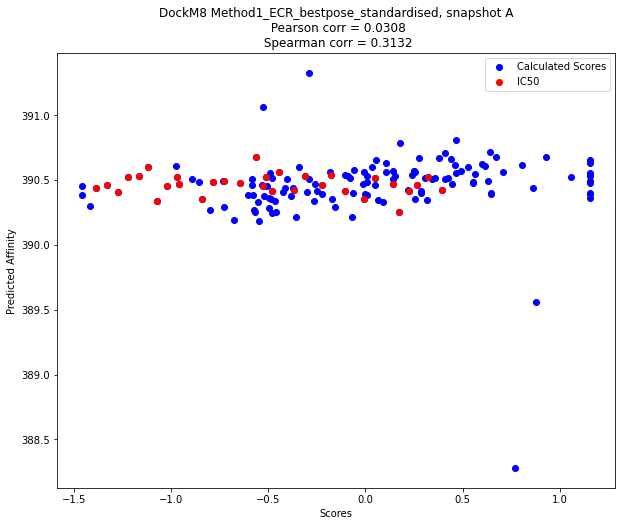

Method1_ECR_RMSD_standardised


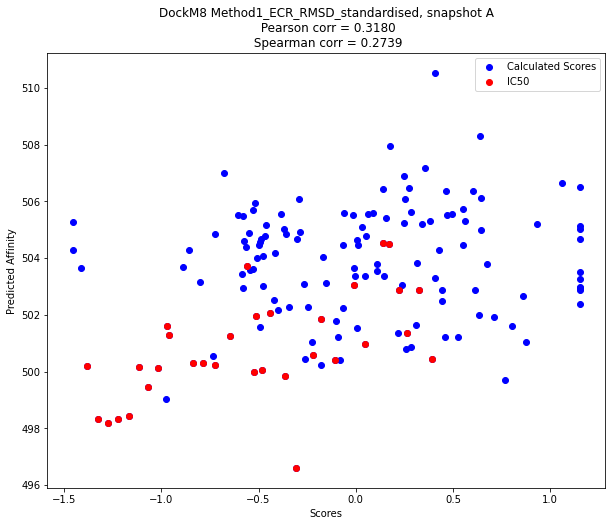

Method1_ECR_spyRMSD_ranked


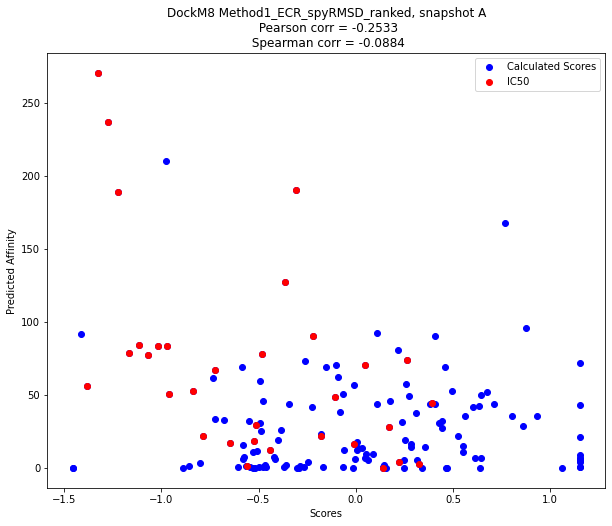

Method1_ECR_RMSD_ranked


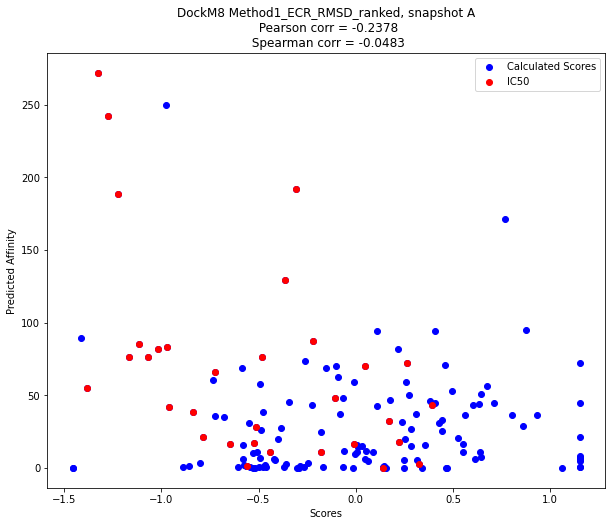

Method1_ECR_spyRMSD_standardised


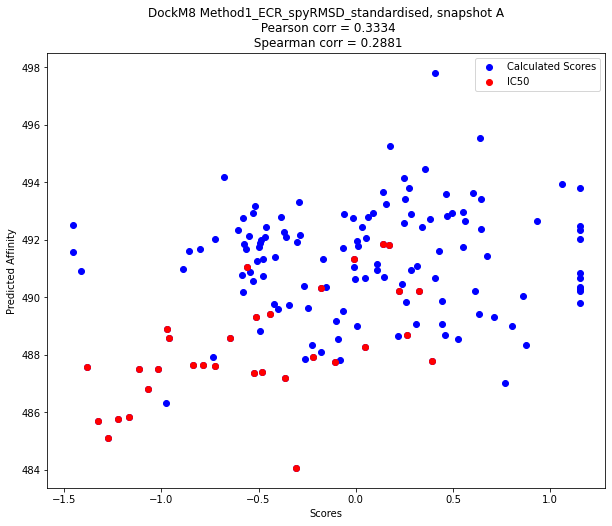

Method1_ECR_bestpose_ranked


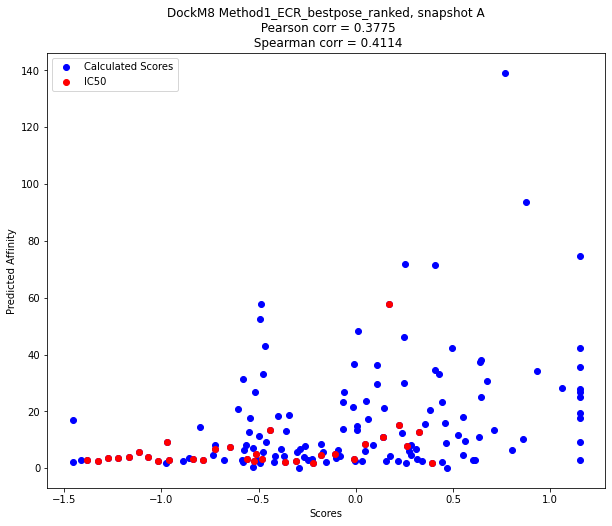

In [20]:
consensus_ranking_generator('method1', common_ID)

#### 2. Average Exponential Consensus Ranking

Method2_ECR_bestpose_standardised


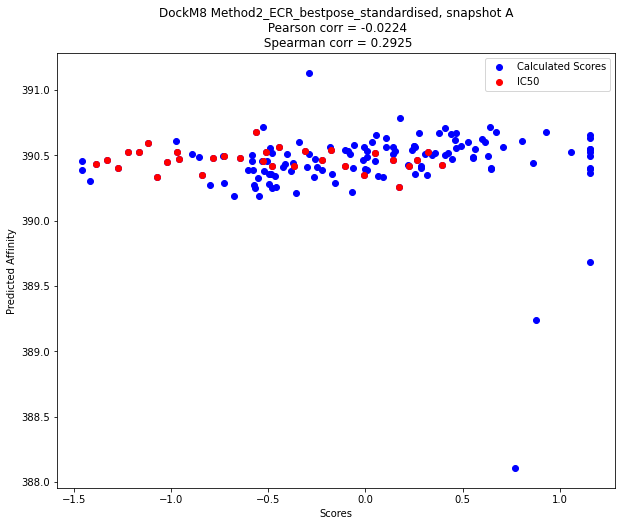

Method2_ECR_RMSD_standardised


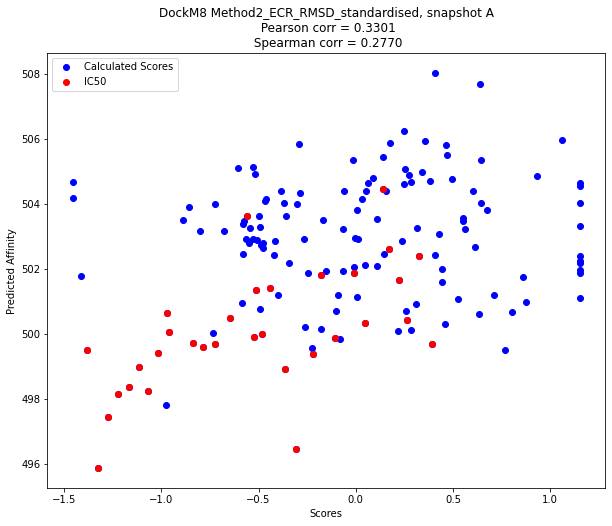

Method2_ECR_spyRMSD_ranked


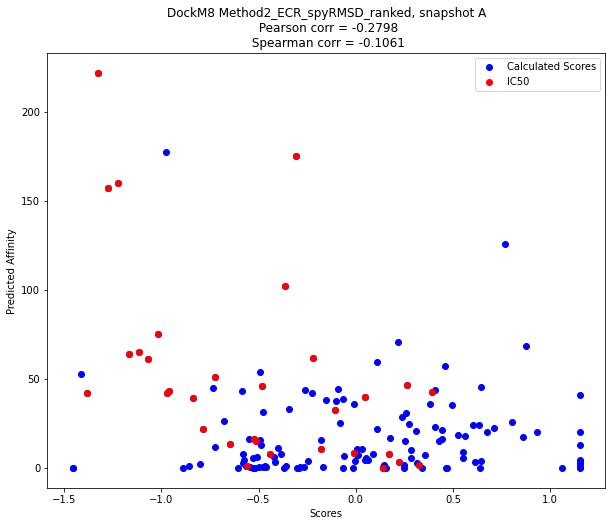

Method2_ECR_RMSD_ranked


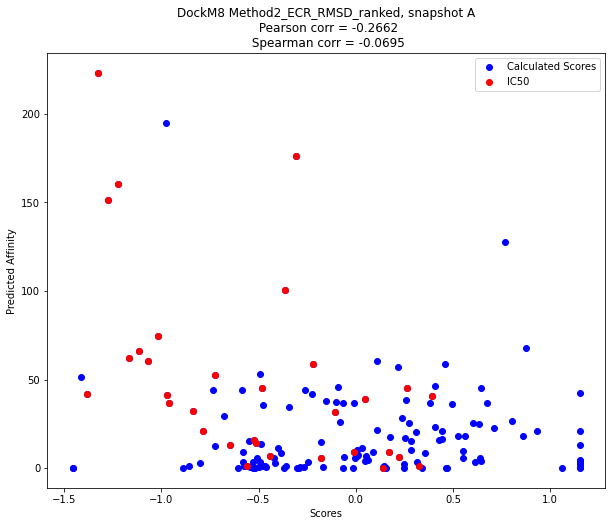

Method2_ECR_spyRMSD_standardised


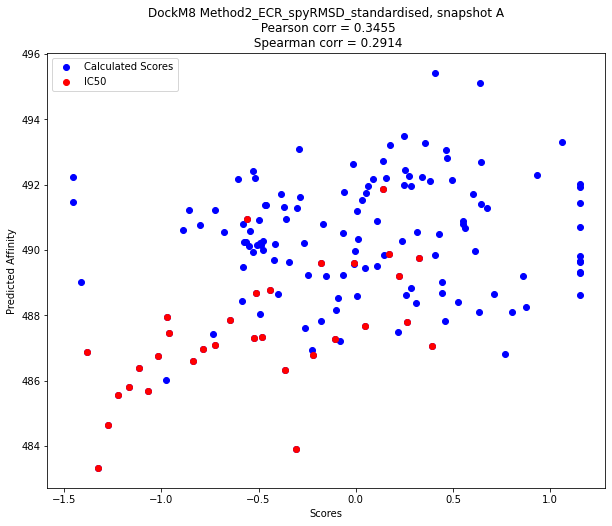

Method2_ECR_bestpose_ranked


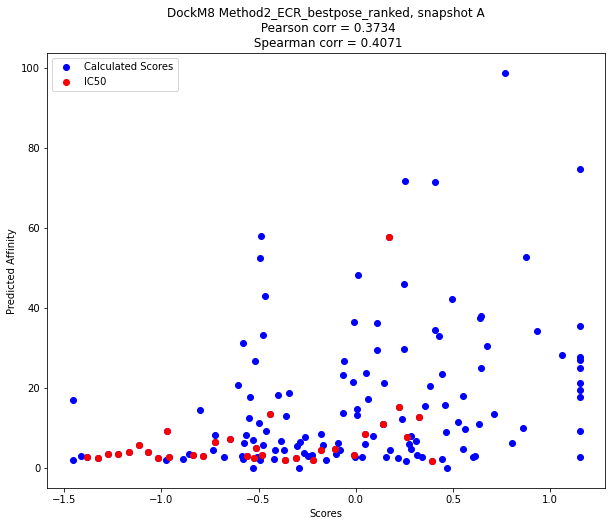

In [21]:
consensus_ranking_generator('method2', common_ID)

#### 3. Z-Score

Method6_Zscore_bestpose_standardised


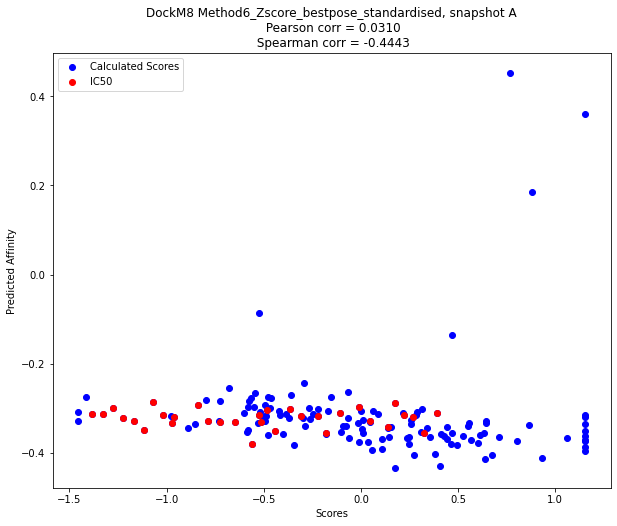

Method6_Zscore_RMSD_standardised


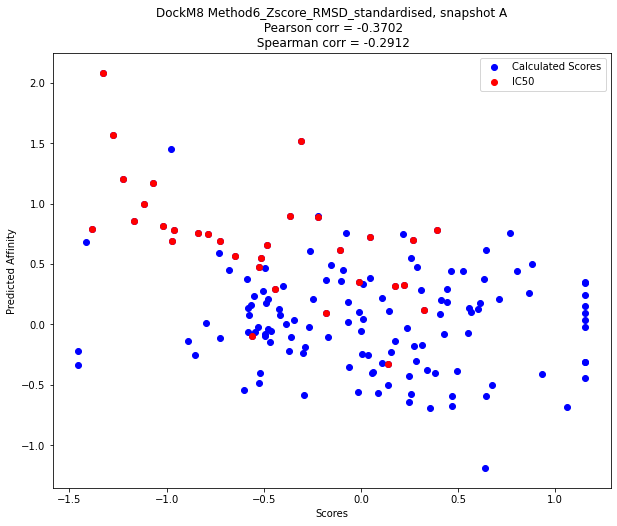

Method6_Zscore_spyRMSD_ranked


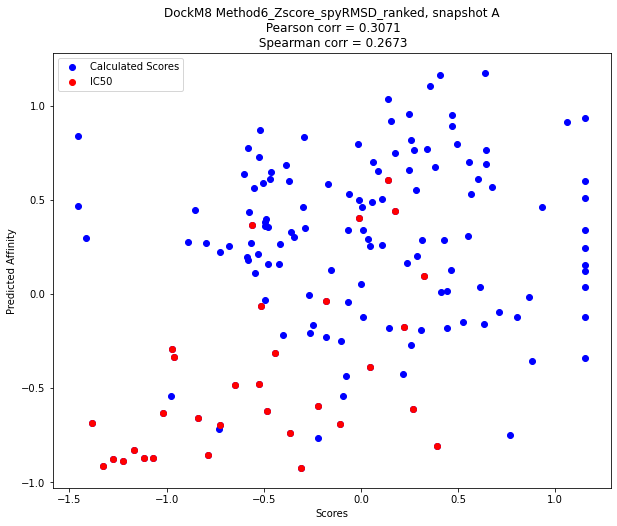

Method6_Zscore_RMSD_ranked


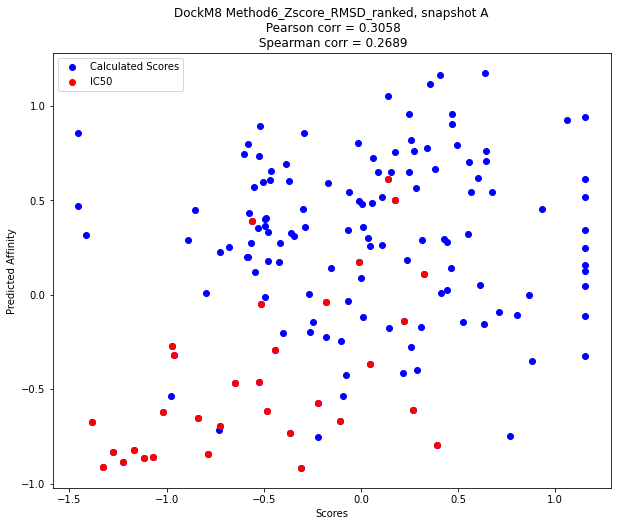

Method6_Zscore_spyRMSD_standardised


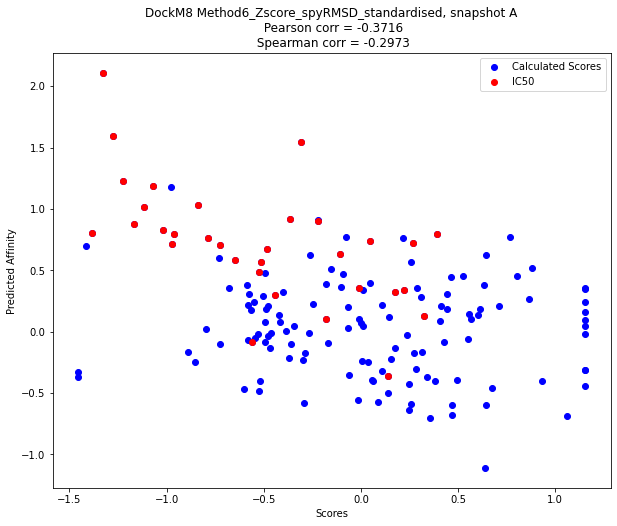

Method6_Zscore_bestpose_ranked


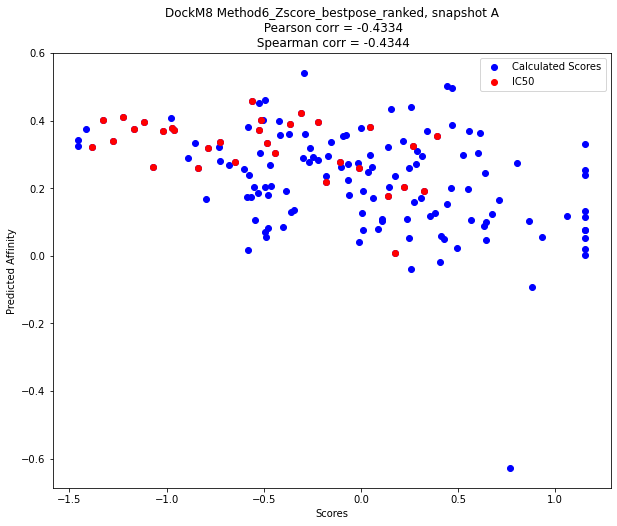

In [22]:
consensus_ranking_generator('method6', common_ID)
